In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout,BatchNormalization
from keras.utils import image_dataset_from_directory

2024-08-06 04:18:12.757327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 04:18:12.757465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 04:18:12.927396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 98%|████████████████████████████████████████ | 338M/346M [00:02<00:00, 163MB/s]
100%|█████████████████████████████████████████| 346M/346M [00:02<00:00, 150MB/s]


In [4]:
import zipfile
zip_ref=zipfile.ZipFile('/kaggle/working/intel-image-classification.zip',mode='r')
zip_ref.extractall('/kaggle/working')
zip_ref.close()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_val_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	fill_mode="nearest"
)


test_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [6]:
!pwd

/kaggle/working


In [7]:
train_path=r'/kaggle/working/seg_train/seg_train'
test_path=r'/kaggle/working/seg_test/seg_test'

train_data = train_val_generator.flow_from_directory(
    train_path,
    target_size=(150,150),
    color_mode='rgb',
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=7,
    subset="training"
)

validation_data = train_val_generator.flow_from_directory(
    train_path,
    target_size=(150,150),
    color_mode='rgb',
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=7,
    subset="validation"
)

test_data = test_generator.flow_from_directory(
test_path,
target_size =(150,150),
color_mode='rgb',
batch_size=32,
class_mode="categorical",
shuffle=True,
seed=7
)

Found 10528 images belonging to 6 classes.
Found 3506 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [8]:

from keras.applications.vgg16 import VGG16

input_tensor = keras.Input(shape=(150, 150, 3))
vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

vgg.trainable=True
set_trainable=False

for layer in vgg.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in vgg.layers:
  print(layer.name,layer.trainable)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [10]:
from keras.models import Model
from keras.callbacks import EarlyStopping
x = vgg.output
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_tensor = Dense(6, activation='softmax')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │    16,779,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,04

 Total params: 32,611,526 (124.40 MB)

 Trainable params: 24,975,238 (95.27 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [11]:
history = model.fit(train_data, epochs=40, validation_data=validation_data,callbacks=[early_stopping])

Epoch 1/40
  1/329 ━━━━━━━━━━━━━━━━━━━━ 2:24:11 26s/step - accuracy: 0.2188 - loss: 3.0747

I0000 00:00:1722883588.564389     157 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722883588.591211     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2845 - loss: 1.8990

W0000 00:00:1722883644.812722     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


329/329 ━━━━━━━━━━━━━━━━━━━━ 111s 258ms/step - accuracy: 0.2847 - loss: 1.8979 - val_accuracy: 0.5054 - val_loss: 1.0447
Epoch 2/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 221ms/step - accuracy: 0.5588 - loss: 1.0069 - val_accuracy: 0.6480 - val_loss: 0.8111
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 222ms/step - accuracy: 0.6815 - loss: 0.7679 - val_accuracy: 0.7239 - val_loss: 0.6626
Epoch 4/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 221ms/step - accuracy: 0.7589 - loss: 0.6330 - val_accuracy: 0.8009 - val_loss: 0.5267
Epoch 5/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 221ms/step - accuracy: 0.7989 - loss: 0.5581 - val_accuracy: 0.8471 - val_loss: 0.4224
Epoch 6/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 221ms/step - accuracy: 0.8432 - loss: 0.4631 - val_accuracy: 0.8197 - val_loss: 0.4836
Epoch 7/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 221ms/step - accuracy: 0.8445 - loss: 0.4688 - val_accuracy: 0.8759 - val_loss: 0.3639
Epoch 8/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 222ms/step - accuracy: 0.8696 - loss: 0.3960 - va

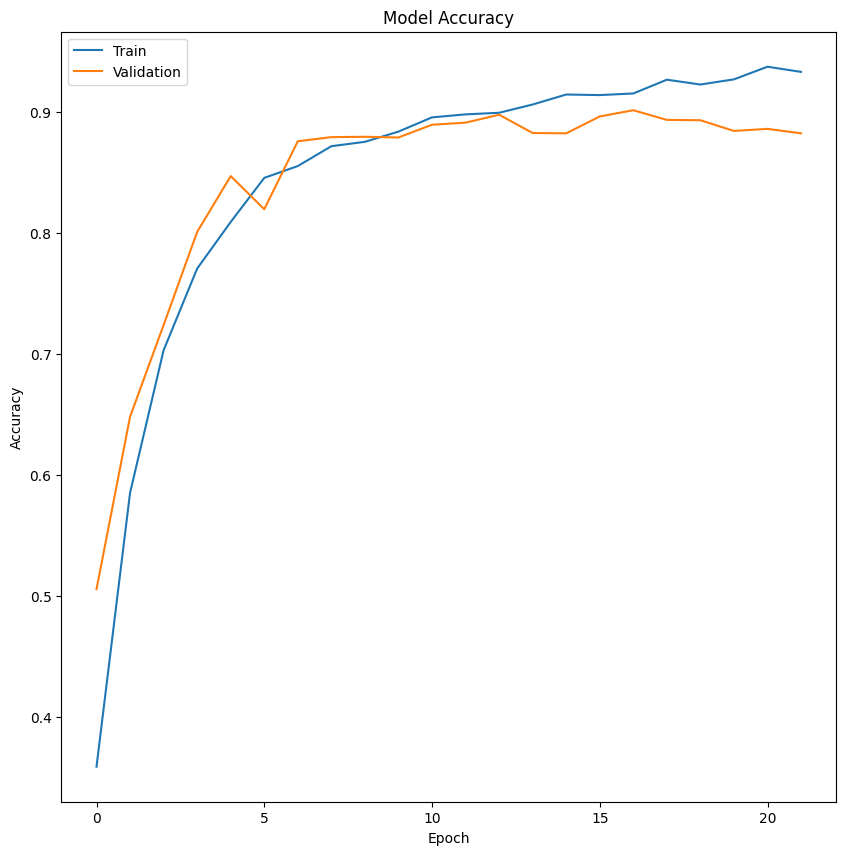

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

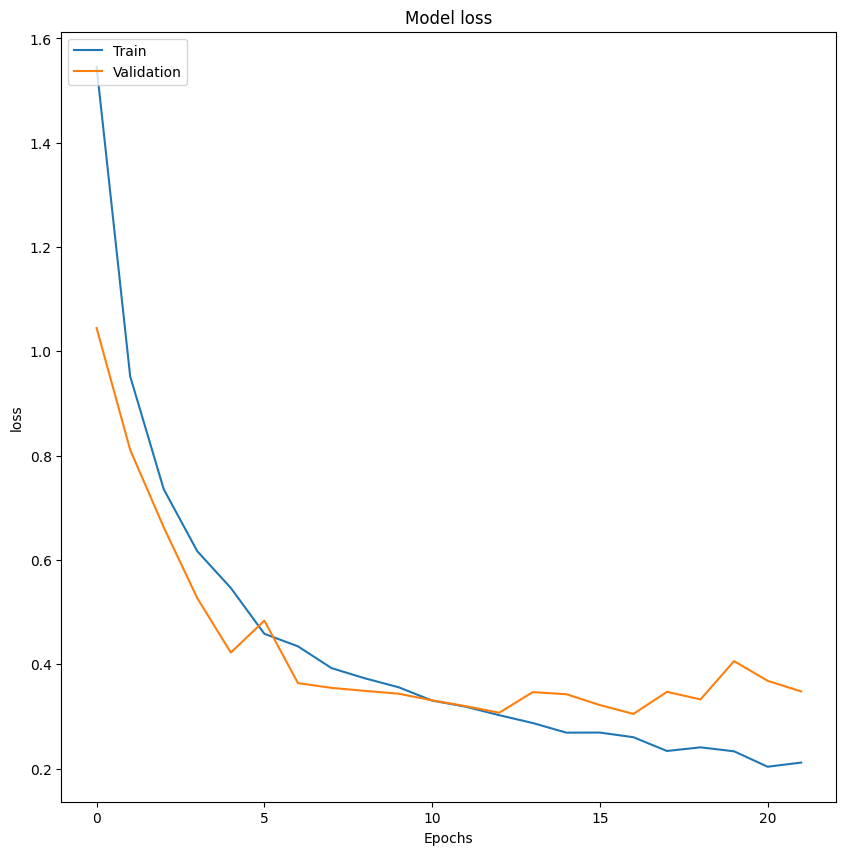

In [15]:
plt.figure(figsize = (10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
model.save('model.h5')